# Source

https://www.kaggle.com/datasets/Cornell-University/arxiv

# Preprocess

In [1]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import glob
import json
import nltk
import os
import re

json_file_path = '_data/3_arXiv_Dataset/arxiv-metadata-oai-snapshot.json'

In [2]:
transformed_data = []
with open(json_file_path, 'r') as file:
    for line in file:
        try:
            entry = json.loads(line)

            transformed_entry = {
                'id': entry['id'],
                'title': entry['title'],
                'category': entry['categories'].split(' '),
                'abstract': entry['abstract'],
                'authors': entry['authors'],
                'authors_parsed': entry['authors_parsed'],
                'update_date': entry['update_date'],
            }

            transformed_data.append(transformed_entry)
        except json.JSONDecodeError:
            print(f"Skipping invalid JSON: {line[:50]}...")
        except KeyError as e:
            print(f"Missing key in entry: {e}")

df = pd.DataFrame(transformed_data)
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list)).any():
        df[col] = df[col].apply(str)

df


,id,title,category,abstract,authors,authors_parsed,update_date
0,0704.0001,Calculation of prompt diphoton production cros...,['hep-ph'],A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']...",2008-11-26
1,0704.0002,Sparsity-certifying Graph Decompositions,"['math.CO', 'cs.CG']","We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'...",2008-12-13
2,0704.0003,The evolution of the Earth-Moon system based o...,['physics.gen-ph'],The evolution of Earth-Moon system is descri...,Hongjun Pan,"[['Pan', 'Hongjun', '']]",2008-01-13
3,0704.0004,A determinant of Stirling cycle numbers counts...,['math.CO'],We show that a determinant of Stirling cycle...,David Callan,"[['Callan', 'David', '']]",2007-05-23
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"['math.CA', 'math.FA']",In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ...",2013-10-15
...,...,...,...,...,...,...,...
2689083,supr-con/9608008,On the origin of the irreversibility line in t...,"['supr-con', 'cond-mat.supr-con']",We report on measurements of the angular dep...,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...","[['Prozorov', 'R.', ''], ['Konczykowski', 'M.'...",2009-10-30
2689084,supr-con/9609001,Nonlinear Response of HTSC Thin Film Microwave...,"['supr-con', 'cond-mat.supr-con']",The non-linear microwave surface impedance o...,"Durga P. Choudhury, Balam A. Willemsen, John S...","[['Choudhury', 'Durga P.', '', 'Physics Depart...",2016-11-18
2689085,supr-con/9609002,Critical State Flux Penetration and Linear Mic...,"['supr-con', 'cond-mat.supr-con']",The vortex contribution to the dc field (H) ...,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...","[['Willemsen', 'Balam A.', '', 'Physics Depart...",2009-10-30
2689086,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,"['supr-con', 'cond-mat.supr-con']",We show that the density of states in an ani...,Yasumasa Hasegawa (Himeji Institute of Technol...,"[['Hasegawa', 'Yasumasa', '', 'Himeji Institut...",2009-10-30


In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andras.janko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andras.janko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andras.janko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocess_scientific_text(text):
    """
    NLTK-based preprocessing for scientific/academic text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Replace LaTeX expressions with placeholders
    # Find patterns like $...$, \begin{equation}...\end{equation}, etc.
    text = re.sub(r'\$.*?\$', ' MATH_EXPR ', text)
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', ' MATH_EXPR ', text, flags=re.DOTALL)

    # Handle special characters carefully
    # Keep hyphens in compound words but remove standalone hyphens
    text = re.sub(r'(?<!\w)-(?!\w)', ' ', text)

    # Handle special scientific notation
    # Replace chemical formulas like H2O with placeholders
    text = re.sub(r'\b[A-Z][a-z]?\d*\b', ' CHEM_FORMULA ', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    processed_tokens = []
    for token in tokens:
        if token.isalnum():
            processed_tokens.append(lemmatizer.lemmatize(token))

    # Join tokens back to text
    return ' '.join(processed_tokens)

df['processed_abstract'] = df['abstract'].apply(preprocess_scientific_text)

# Extract primary category (first in the list)
df['primary_category'] = df['category'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x[0])
df


,id,title,category,abstract,authors,authors_parsed,update_date,processed_title,processed_abstract,primary_category
0,0704.0001,Calculation of prompt diphoton production cros...,['hep-ph'],A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']...",2008-11-26,calculation of prompt diphoton production cros...,a fully differential calculation in perturbati...,hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,"['math.CO', 'cs.CG']","We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'...",2008-12-13,graph decomposition,we describe a new algorithm the game with colo...,math.CO
2,0704.0003,The evolution of the Earth-Moon system based o...,['physics.gen-ph'],The evolution of Earth-Moon system is descri...,Hongjun Pan,"[['Pan', 'Hongjun', '']]",2008-01-13,the evolution of the system based on the dark ...,the evolution of system is described by the da...,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,['math.CO'],We show that a determinant of Stirling cycle...,David Callan,"[['Callan', 'David', '']]",2007-05-23,a determinant of stirling cycle number count u...,we show that a determinant of stirling cycle n...,math.CO
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"['math.CA', 'math.FA']",In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ...",2013-10-15,from dyadic to,in this paper we show how to compute the norm ...,math.CA
...,...,...,...,...,...,...,...,...,...,...
2689083,supr-con/9608008,On the origin of the irreversibility line in t...,"['supr-con', 'cond-mat.supr-con']",We report on measurements of the angular dep...,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...","[['Prozorov', 'R.', ''], ['Konczykowski', 'M.'...",2009-10-30,on the origin of the irreversibility line in t...,we report on measurement of the angular depend...,supr-con
2689084,supr-con/9609001,Nonlinear Response of HTSC Thin Film Microwave...,"['supr-con', 'cond-mat.supr-con']",The non-linear microwave surface impedance o...,"Durga P. Choudhury, Balam A. Willemsen, John S...","[['Choudhury', 'Durga P.', '', 'Physics Depart...",2016-11-18,nonlinear response of htsc thin film microwave...,the microwave surface impedance of patterned y...,supr-con
2689085,supr-con/9609002,Critical State Flux Penetration and Linear Mic...,"['supr-con', 'cond-mat.supr-con']",The vortex contribution to the dc field (H) ...,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...","[['Willemsen', 'Balam A.', '', 'Physics Depart...",2009-10-30,critical state flux penetration and linear mic...,the vortex contribution to the dc field h depe...,supr-con
2689086,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,"['supr-con', 'cond-mat.supr-con']",We show that the density of states in an ani...,Yasumasa Hasegawa (Himeji Institute of Technol...,"[['Hasegawa', 'Yasumasa', '', 'Himeji Institut...",2009-10-30,density of state and nmr relaxation rate in an...,we show that the density of state in an anisot...,supr-con


In [5]:
print("\nOriginal abstract excerpt:", df['abstract'].iloc[0][:150])
print("Processed abstract excerpt:", df['processed_abstract'].iloc[0][:150])


Original abstract excerpt:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders.
Processed abstract excerpt: a fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pair at hadron collider all 


### Forgot the stopwords:

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if not isinstance(text, str):
        return ""

    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    return ' '.join(filtered_tokens)

print("BEFORE STOPWORD REMOVAL:")
print("Abstract example:", df['processed_abstract'].iloc[0][:150])
print("-" * 80)

df['processed_abstract'] = df['processed_abstract'].apply(remove_stopwords)

print("AFTER STOPWORD REMOVAL:")
print("Abstract example:", df['processed_abstract'].iloc[0][:150])
df

BEFORE STOPWORD REMOVAL:
Abstract example: a fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pair at hadron collider all 
--------------------------------------------------------------------------------


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andras.janko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AFTER STOPWORD REMOVAL:
Abstract example: fully differential calculation perturbative quantum chromodynamics presented production massive photon pair hadron collider order perturbative contrib


,id,title,category,abstract,authors,authors_parsed,update_date,processed_title,processed_abstract,primary_category
0,0704.0001,Calculation of prompt diphoton production cros...,['hep-ph'],A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']...",2008-11-26,calculation of prompt diphoton production cros...,fully differential calculation perturbative qu...,hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,"['math.CO', 'cs.CG']","We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'...",2008-12-13,graph decomposition,describe new algorithm game color use obtain c...,math.CO
2,0704.0003,The evolution of the Earth-Moon system based o...,['physics.gen-ph'],The evolution of Earth-Moon system is descri...,Hongjun Pan,"[['Pan', 'Hongjun', '']]",2008-01-13,the evolution of the system based on the dark ...,evolution system described dark matter field f...,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,['math.CO'],We show that a determinant of Stirling cycle...,David Callan,"[['Callan', 'David', '']]",2007-05-23,a determinant of stirling cycle number count u...,show determinant stirling cycle number count u...,math.CO
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"['math.CA', 'math.FA']",In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ...",2013-10-15,from dyadic to,paper show compute norm 0 using dyadic grid re...,math.CA
...,...,...,...,...,...,...,...,...,...,...
2689083,supr-con/9608008,On the origin of the irreversibility line in t...,"['supr-con', 'cond-mat.supr-con']",We report on measurements of the angular dep...,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...","[['Prozorov', 'R.', ''], ['Konczykowski', 'M.'...",2009-10-30,on the origin of the irreversibility line in t...,report measurement angular dependence irrevers...,supr-con
2689084,supr-con/9609001,Nonlinear Response of HTSC Thin Film Microwave...,"['supr-con', 'cond-mat.supr-con']",The non-linear microwave surface impedance o...,"Durga P. Choudhury, Balam A. Willemsen, John S...","[['Choudhury', 'Durga P.', '', 'Physics Depart...",2016-11-18,nonlinear response of htsc thin film microwave...,microwave surface impedance patterned ybco thi...,supr-con
2689085,supr-con/9609002,Critical State Flux Penetration and Linear Mic...,"['supr-con', 'cond-mat.supr-con']",The vortex contribution to the dc field (H) ...,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...","[['Willemsen', 'Balam A.', '', 'Physics Depart...",2009-10-30,critical state flux penetration and linear mic...,vortex contribution dc field h dependent micro...,supr-con
2689086,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,"['supr-con', 'cond-mat.supr-con']",We show that the density of states in an ani...,Yasumasa Hasegawa (Himeji Institute of Technol...,"[['Hasegawa', 'Yasumasa', '', 'Himeji Institut...",2009-10-30,density of state and nmr relaxation rate in an...,show density state anisotropic superconductor ...,supr-con


In [7]:
df = df.drop(columns=['id', 'authors', 'authors_parsed', 'category', 'processed_title', 'title'])
df

,abstract,update_date,processed_abstract,primary_category
0,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,hep-ph
1,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,describe new algorithm game color use obtain c...,math.CO
2,The evolution of Earth-Moon system is descri...,2008-01-13,evolution system described dark matter field f...,physics.gen-ph
3,We show that a determinant of Stirling cycle...,2007-05-23,show determinant stirling cycle number count u...,math.CO
4,In this paper we show how to compute the $\L...,2013-10-15,paper show compute norm 0 using dyadic grid re...,math.CA
...,...,...,...,...
2689083,We report on measurements of the angular dep...,2009-10-30,report measurement angular dependence irrevers...,supr-con
2689084,The non-linear microwave surface impedance o...,2016-11-18,microwave surface impedance patterned ybco thi...,supr-con
2689085,The vortex contribution to the dc field (H) ...,2009-10-30,vortex contribution dc field h dependent micro...,supr-con
2689086,We show that the density of states in an ani...,2009-10-30,show density state anisotropic superconductor ...,supr-con


In [8]:
df['primary_category'] = df['primary_category'].str.split('.').str[0]
df

,abstract,update_date,processed_abstract,primary_category
0,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,hep-ph
1,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,describe new algorithm game color use obtain c...,math
2,The evolution of Earth-Moon system is descri...,2008-01-13,evolution system described dark matter field f...,physics
3,We show that a determinant of Stirling cycle...,2007-05-23,show determinant stirling cycle number count u...,math
4,In this paper we show how to compute the $\L...,2013-10-15,paper show compute norm 0 using dyadic grid re...,math
...,...,...,...,...
2689083,We report on measurements of the angular dep...,2009-10-30,report measurement angular dependence irrevers...,supr-con
2689084,The non-linear microwave surface impedance o...,2016-11-18,microwave surface impedance patterned ybco thi...,supr-con
2689085,The vortex contribution to the dc field (H) ...,2009-10-30,vortex contribution dc field h dependent micro...,supr-con
2689086,We show that the density of states in an ani...,2009-10-30,show density state anisotropic superconductor ...,supr-con


- cs - Computer Science
- math - Mathematics
- cond-mat - Condensed Matter Physics
- astro-ph - Astrophysics
- physics - General Physics
- hep-ph - High Energy Physics - Phenomenology
- quant-ph - Quantum Physics
- hep-th - High Energy Physics - Theory
- gr-qc - General Relativity and Quantum Cosmology
- eess - Electrical Engineering and Systems Science
- stat - Statistics
- nucl-th - Nuclear Theory
- math-ph - Mathematical Physics
- q-bio - Quantitative Biology
- hep-ex - High Energy Physics - Experiment
- nlin - Nonlinear Sciences
- hep-lat - High Energy Physics - Lattice
- q-fin - Quantitative Finance
- nucl-ex - Nuclear Experiment
- econ - Economics

TO:
1. Computer Science (cs)

2. Mathematics (math)

3. Physics
- Condensed Matter (cond-mat)
- General Physics (physics)
- Nonlinear Sciences (nlin)

4. Astrophysics & Cosmology
- Astrophysics (astro-ph)
- General Relativity and Quantum Cosmology (gr-qc)

5. High Energy Physics
- HEP - Phenomenology (hep-ph)
- HEP - Theory (hep-th)
- HEP - Experiment (hep-ex)
- HEP - Lattice (hep-lat)

6. Quantum Physics (quant-ph)

7. Nuclear Physics
- Nuclear Theory (nucl-th)
- Nuclear Experiment (nucl-ex)


8. Engineering & Systems
- Electrical Engineering and Systems Science (eess)


9. Statistics & Mathematical Physics
- Statistics (stat)
- Mathematical Physics (math-ph)


10. Life Sciences
- Quantitative Biology (q-bio)


11. Economics & Finance
- Quantitative Finance (q-fin)
- Economics (econ)


In [10]:
top_20_categories = df['primary_category'].value_counts().nlargest(20).index.tolist()
top_20_categories

['cs',
 'math',
 'cond-mat',
 'astro-ph',
 'physics',
 'hep-ph',
 'quant-ph',
 'hep-th',
 'gr-qc',
 'eess',
 'stat',
 'nucl-th',
 'math-ph',
 'q-bio',
 'hep-ex',
 'nlin',
 'hep-lat',
 'q-fin',
 'nucl-ex',
 'econ']

ORIGINAL TOP 20 CATEGORIES
primary_category
cs          598894
math        526484
cond-mat    325484
astro-ph    312816
physics     189380
hep-ph      135874
quant-ph    115832
hep-th      107945
gr-qc        66017
eess         57767
stat         53331
nucl-th      34029
math-ph      32445
q-bio        30425
hep-ex       23701
nlin         19635
hep-lat      18441
q-fin        11989
nucl-ex      11843
econ          8553
Name: count, dtype: int64


MERGED CATEGORIES
merged_category
Computer Science                     598894
Physics                              534499
Mathematics                          526484
Astrophysics & Cosmology             378833
High Energy Physics                  285961
Quantum Physics                      115832
Statistics & Mathematical Physics     85776
Engineering & Systems                 57767
Nuclear Physics                       45872
Life Sciences                         30425
Economics & Finance                   20542
Name: count, dtype: int64


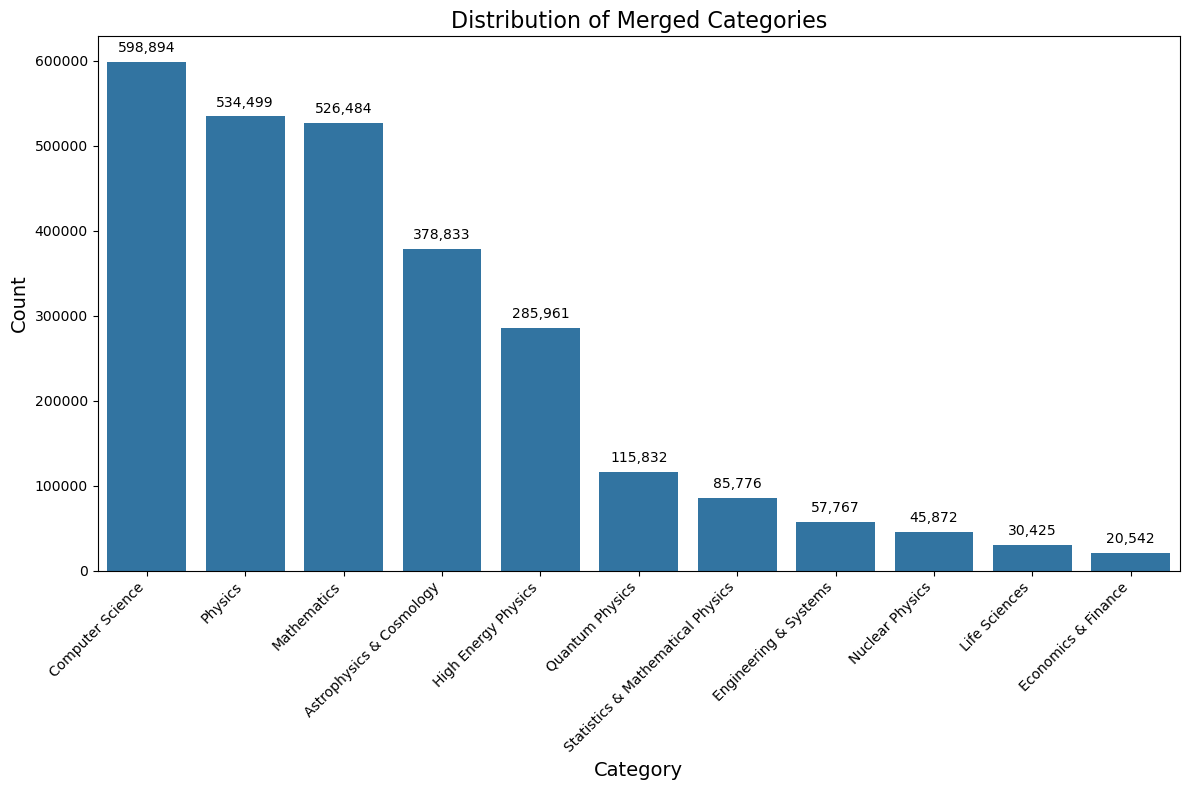

,abstract,update_date,processed_abstract,primary_category,merged_category
0,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,hep-ph,High Energy Physics
1,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,describe new algorithm game color use obtain c...,math,Mathematics
2,The evolution of Earth-Moon system is descri...,2008-01-13,evolution system described dark matter field f...,physics,Physics
3,We show that a determinant of Stirling cycle...,2007-05-23,show determinant stirling cycle number count u...,math,Mathematics
4,In this paper we show how to compute the $\L...,2013-10-15,paper show compute norm 0 using dyadic grid re...,math,Mathematics
...,...,...,...,...,...
2688170,"Until recently, only science-fiction authors...",2007-05-23,recently author ventured use term teleportatio...,quant-ph,Quantum Physics
2688171,Some recent developments of the dissipative ...,2009-10-31,recent development dissipative quantum model b...,quant-ph,Quantum Physics
2688172,This paper has been withdrawn by the authors...,2007-05-23,paper ha withdrawn author due error first note...,quant-ph,Quantum Physics
2688173,Classical messages can be sent via a noisy q...,2007-05-23,classical message sent via noisy quantum chann...,quant-ph,Quantum Physics


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe to only include documents from the top 20 categories
filtered_df = df[df['primary_category'].isin(top_20_categories)].copy()

# Define the category mapping according to our merged groups
category_mapping = {
    'cs': 'Computer Science',
    'math': 'Mathematics',

    # Physics group
    'cond-mat': 'Physics',
    'physics': 'Physics',
    'nlin': 'Physics',

    # Astrophysics & Cosmology group
    'astro-ph': 'Astrophysics & Cosmology',
    'gr-qc': 'Astrophysics & Cosmology',

    # High Energy Physics group
    'hep-ph': 'High Energy Physics',
    'hep-th': 'High Energy Physics',
    'hep-ex': 'High Energy Physics',
    'hep-lat': 'High Energy Physics',

    # Quantum Physics
    'quant-ph': 'Quantum Physics',

    # Nuclear Physics group
    'nucl-th': 'Nuclear Physics',
    'nucl-ex': 'Nuclear Physics',

    # Engineering & Systems
    'eess': 'Engineering & Systems',

    # Statistics & Mathematical Physics
    'stat': 'Statistics & Mathematical Physics',
    'math-ph': 'Statistics & Mathematical Physics',

    # Life Sciences
    'q-bio': 'Life Sciences',

    # Economics & Finance
    'q-fin': 'Economics & Finance',
    'econ': 'Economics & Finance'
}

# Apply the mapping to create a new column with the merged categories
filtered_df['merged_category'] = filtered_df['primary_category'].map(category_mapping)

# Display the distribution of original vs. merged categories
print("="*80)
print("ORIGINAL TOP 20 CATEGORIES")
print("="*80)
original_counts = filtered_df['primary_category'].value_counts()
print(original_counts)

print("\n")
print("="*80)
print("MERGED CATEGORIES")
print("="*80)
merged_counts = filtered_df['merged_category'].value_counts()
print(merged_counts)

# Visualize the merged categories
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=merged_counts.index, y=merged_counts.values)
plt.title('Distribution of Merged Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Return the processed dataframe for further analysis
filtered_df

In [13]:
filtered_df = filtered_df.drop(columns=['primary_category'])
filtered_df.to_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv", index=False)